## A. Importing Libraries

In [1]:
#import libraries
import pandas as pd
import numpy as np

#Coordinates
import geocoder
from geopy.geocoders import Nominatim
import requests

# Visualizations
import matplotlib
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import folium
import matplotlib.pyplot as plt

# Clustering/Machine Learning
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


## 1. Reading NYC Health Data

In [2]:
#CSV File provided from NYC Health Website
infectionrates = pd.read_csv("nycinfectionrates.csv")
infectionrates

,ZIP,Neighborhood,Borough,Cases,"Cases per 100,000","Deaths per 100,000",Percent positive<br>(of people tested)
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,397,1684.84,101.85,9.16
1,10002,Chinatown/Lower East Side,Manhattan,1139,1483.93,204.55,13.02
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,488,907.04,63.20,7.12
3,10004,Financial District,Manhattan,33,903.96,27.39,7.42
4,10005,Financial District,Manhattan,69,821.81,23.82,6.64
...,...,...,...,...,...,...,...
172,11691,Edgemere/Far Rockaway,Queens,2510,3875.91,560.54,20.47
173,11692,Arverne/Edgemere,Queens,653,3245.49,457.25,18.93
174,11693,Arverne/Broad Channel,Queens,341,2754.16,242.30,20.65
175,11694,Belle Harbor-Neponsit/Rockaway Park,Queens,750,3684.46,427.40,21.36


In [3]:
infectionrates['Neighborhood'].value_counts()

Lenox Hill/Upper East Side                                   3
Financial District                                           3
Hell's Kitchen/Midtown Manhattan                             3
Lincoln Square                                               2
Ozone Park                                                   2
                                                            ..
Woodside                                                     1
Bayside (North)/Bayside (South)                              1
Belle Harbor-Neponsit/Rockaway Park                          1
Charleston/Prince's Bay/Woodrow                              1
Alphabet City/East Village/Stuyvesant Town-Cooper Village    1
Name: Neighborhood, Length: 162, dtype: int64

## 2. Using Geocoder to obtain coordinates

In [4]:
#testing geocoder
g = geocoder.arcgis('10006') #neighborhood zipcode
coordinates = g.latlng
coordinates

[40.708935000000054, -74.01316999999995]

In [5]:
#define a function to get coordinates
def get_coordinates(zipcode):
    # initialize your variable to None
    coordinates = None
    # loop until you get the coordinates
    while(coordinates is None):
        g = geocoder.arcgis('{}'.format(zipcode))
        coordinates = g.latlng
    return coordinates


In [6]:
#Applying function to zipcodes in data frame (this takes some time)
nyc_coordinates=[get_coordinates(zipcode) for zipcode in infectionrates["ZIP"].tolist()]

In [7]:
#checking work
nyc_coordinates

[[40.75095500000003, -73.99810999999994],
 [40.71647500000006, -73.98844999999994],
 [40.73236000000003, -73.98908999999998],
 [40.70402740000003, -74.01220499999994],
 [40.705799100000036, -74.00769459999998],
 [40.708935000000054, -74.01316999999995],
 [40.71409500000004, -74.00948999999997],
 [40.72748000000007, -73.97945499999997],
 [40.73916500000007, -73.98290499999996],
 [40.74127000000004, -74.00142499999998],
 [40.725970000000075, -73.99796999999995],
 [40.72033000000005, -74.00556469999998],
 [40.733880000000056, -74.00542999999993],
 [40.74591000000004, -73.97853999999995],
 [40.75192000000004, -73.97360499999996],
 [40.759150000000034, -73.99831999999998],
 [40.766755000000046, -73.98891499999996],
 [40.77018000000004, -73.96028499999994],
 [40.75929000000008, -73.96927999999997],
 [40.77568000000008, -73.98262999999997],
 [40.78605090000008, -73.97620439999997],
 [40.797570000000064, -73.96781499999997],
 [40.802725000000066, -73.95296999999994],
 [40.81172860000004, -73.9

In [8]:
# create temporary dataframe to hold coordinates
df_temp = pd.DataFrame(nyc_coordinates, columns=['Latitude', 'Longitude'])

In [9]:
# merge the coordinates into the original dataframe
df = infectionrates.copy()
df['Latitude'] = df_temp['Latitude']
df['Longitude'] = df_temp['Longitude']

In [10]:
df.head()

,ZIP,Neighborhood,Borough,Cases,"Cases per 100,000","Deaths per 100,000",Percent positive<br>(of people tested),Latitude,Longitude
0,10001,Chelsea/NoMad/West Chelsea,Manhattan,397,1684.84,101.85,9.16,40.750955,-73.998110
1,10002,Chinatown/Lower East Side,Manhattan,1139,1483.93,204.55,13.02,40.716475,-73.988450
2,10003,East Village/Gramercy/Greenwich Village,Manhattan,488,907.04,63.20,7.12,40.732360,-73.989090
3,10004,Financial District,Manhattan,33,903.96,27.39,7.42,40.704027,-74.012205
4,10005,Financial District,Manhattan,69,821.81,23.82,6.64,40.705799,-74.007695


In [11]:
#saving df to csv
df.to_csv('nyc_infection_rates_coordinates')

## 3. Map of New York and Neighborhoods (Zipcode)

In [12]:
# get the coordinates of Kuala Lumpur
address = 'Manhattan, New York, USA'

geolocator = Nominatim(user_agent="my-application")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Manhattan New York, NY {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Manhattan New York, NY 40.7896239, -73.9598939.


In [67]:
# create map of New York using latitude and longitude values
map_ny = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['ZIP']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_ny)  
    
map_ny

## 5. Using the Foursquare API to find Venues of Neighborhoods

In [14]:
# define Foursquare Credentials and Version
CLIENT_ID = 'CG2J12QHXVN4NPJH1PXLVHLTEIFUD3LGWPPO4KA0V5L0TB3L' # your Foursquare ID
CLIENT_SECRET = 'VCQF0K4RK0HOGNWPKHPEBYRFPW4C25J43311YMK0EVGTB2WJ' # your Foursquare Secret
VERSION = '20200612' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: CG2J12QHXVN4NPJH1PXLVHLTEIFUD3LGWPPO4KA0V5L0TB3L
CLIENT_SECRET:VCQF0K4RK0HOGNWPKHPEBYRFPW4C25J43311YMK0EVGTB2WJ


In [15]:
radius = 1000
LIMIT = 100

venues = []

#API request URL
for lat, long, ZIP, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['ZIP'], df['Borough'], df['Neighborhood']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    #GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            ZIP, 
            borough,
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [16]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['ZIP', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(13924, 9)


,ZIP,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,10001,Manhattan,Chelsea/NoMad/West Chelsea,40.750955,-73.99811,Bluestone Lane,40.752068,-73.998848,Coffee Shop
1,10001,Manhattan,Chelsea/NoMad/West Chelsea,40.750955,-73.99811,B&H Photo Video,40.753277,-73.996470,Camera Store
2,10001,Manhattan,Chelsea/NoMad/West Chelsea,40.750955,-73.99811,New York Pizza Suprema,40.750124,-73.994992,Pizza Place
3,10001,Manhattan,Chelsea/NoMad/West Chelsea,40.750955,-73.99811,Music Choice,40.752632,-73.994585,Music Venue
4,10001,Manhattan,Chelsea/NoMad/West Chelsea,40.750955,-73.99811,You Should Be Dancing…..! / Club 412,40.750306,-73.994743,Dance Studio


In [17]:
#save as csv file
#venues_df.to_csv('venues_by_zip.csv')
#use venues_by_zip for analysis below.

In [18]:
## Check how many venues were returned for each zipcode
venues_df.groupby(["ZIP"]).count()

,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
ZIP,,,,,,,,
10001,100,100,100,100,100,100,100,100
10002,100,100,100,100,100,100,100,100
10003,100,100,100,100,100,100,100,100
10004,100,100,100,100,100,100,100,100
10005,100,100,100,100,100,100,100,100
...,...,...,...,...,...,...,...,...
11691,40,40,40,40,40,40,40,40
11692,32,32,32,32,32,32,32,32
11693,80,80,80,80,80,80,80,80


In [19]:
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))

There are 453 uniques categories.


## 6. Zip/Neighborhood Analysis

In [20]:
# one hot encoding
ny_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['ZIP'] = venues_df['ZIP'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

print(ny_onehot.shape)
ny_onehot.head()

(13924, 454)


,ZIP,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#grouping rows by neighborhoods and taking the mean of occurances in each category
ny_grouped = ny_onehot.groupby(["ZIP"]).mean().reset_index()

print(ny_grouped.shape)
ny_grouped

(177, 454)


,ZIP,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,...,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.01,0.0,0.0
1,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,...,0.0,0.0,0.030,0.01,0.0,0.0,0.0,0.00,0.0,0.0
2,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,...,0.0,0.0,0.020,0.02,0.0,0.0,0.0,0.02,0.0,0.0
3,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,...,0.0,0.0,0.000,0.03,0.0,0.0,0.0,0.00,0.0,0.0
4,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,...,0.0,0.0,0.000,0.03,0.0,0.0,0.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,11691,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.00,0.0,0.0
173,11692,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.00,0.0,0.0
174,11693,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.025,0.00,0.0,0.0,0.0,0.00,0.0,0.0
175,11694,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000,0.00,0.0,0.0,0.0,0.00,0.0,0.0


In [22]:
#top 10 venues for by neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns by number of top venues
areaColumns = ['ZIP']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['ZIP'] = ny_grouped['ZIP']

for ind in np.arange(ny_grouped.shape[0]):
    row_categories = ny_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(177, 11)


,ZIP,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,10001,Art Gallery,Coffee Shop,Gym / Fitness Center,Pizza Place,Lounge,Music Venue,Bagel Shop,American Restaurant,Hotel,Park
1,10002,Sandwich Place,Ice Cream Shop,Coffee Shop,Mexican Restaurant,French Restaurant,Chinese Restaurant,Pizza Place,Asian Restaurant,Italian Restaurant,Wine Bar
2,10003,Ice Cream Shop,Juice Bar,Coffee Shop,Cosmetics Shop,Café,New American Restaurant,Salad Place,Mediterranean Restaurant,Pizza Place,Bagel Shop
3,10004,Coffee Shop,Mexican Restaurant,Park,Pizza Place,Bar,Gym,Wine Shop,Gym / Fitness Center,Monument / Landmark,Café
4,10005,Coffee Shop,Pizza Place,Gym / Fitness Center,Café,Juice Bar,Mexican Restaurant,Wine Shop,American Restaurant,Falafel Restaurant,Cocktail Bar
...,...,...,...,...,...,...,...,...,...,...,...
172,11691,Beach,Chinese Restaurant,Pizza Place,Donut Shop,Sandwich Place,Breakfast Spot,Bank,Supermarket,Business Service,Gym
173,11692,Beach,Surf Spot,Donut Shop,Sandwich Place,Brewery,Gas Station,Bed & Breakfast,Gym / Fitness Center,Thai Restaurant,Grocery Store
174,11693,Beach,Pizza Place,Fast Food Restaurant,Beach Bar,Bar,Latin American Restaurant,Seafood Restaurant,Board Shop,Bagel Shop,BBQ Joint
175,11694,Beach,Deli / Bodega,Pub,Pizza Place,Donut Shop,Mexican Restaurant,Bakery,Bagel Shop,Park,Pharmacy


## 7. Cluster Zip/Neighborhoods

In [23]:
# set number of clusters
kclusters = 10

ny_clustering = ny_grouped.drop(["ZIP"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(ny_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 1, 1, 6, 6, 6, 6, 1, 6, 4], dtype=int32)

In [24]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
ny_merged = ny_grouped.copy()

# add clustering labels
ny_merged["Cluster Labels"] = kmeans.labels_

In [25]:
#adding coordinates
ny_merged['Latitude'] = df['Latitude']
ny_merged['Longitude'] = df['Longitude']

In [26]:
#checking work
ny_merged.head()

,ZIP,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit,Cluster Labels,Latitude,Longitude
0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,...,0.00,0.0,0.0,0.0,0.01,0.0,0.0,6,40.750955,-73.998110
1,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.01,0.0,0.0,0.0,0.00,0.0,0.0,1,40.716475,-73.988450
2,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.02,0.0,0.0,0.0,0.02,0.0,0.0,1,40.732360,-73.989090
3,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,...,0.03,0.0,0.0,0.0,0.00,0.0,0.0,6,40.704027,-74.012205
4,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,...,0.03,0.0,0.0,0.0,0.00,0.0,0.0,6,40.705799,-74.007695


In [27]:
#save to data frame
#ny_merged.to_csv('ny_merged.csv')

## 8. Analyzing Clusters

In [28]:
#visualizing clusters

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_merged['Latitude'], ny_merged['Longitude'], ny_merged['ZIP'], ny_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [29]:
neighborhoods_venues_sorted['Cluster Labels']= kmeans.labels_

In [30]:
#Cluster 1 (RED)
cluster1 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 0]
cluster1.head(10)

,ZIP,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
126,11354,Korean Restaurant,Pizza Place,Donut Shop,Supermarket,Bar,Grocery Store,Pharmacy,Coffee Shop,Chinese Restaurant,Japanese Restaurant,0
127,11355,Korean Restaurant,Chinese Restaurant,Asian Restaurant,Indian Restaurant,Deli / Bodega,Pizza Place,Bar,Shanghai Restaurant,Park,Convenience Store,0


In [31]:
#Cluster 2 (Purple)
cluster2 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 1]
cluster2.head(10)

,ZIP,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,10002,Sandwich Place,Ice Cream Shop,Coffee Shop,Mexican Restaurant,French Restaurant,Chinese Restaurant,Pizza Place,Asian Restaurant,Italian Restaurant,Wine Bar,1
2,10003,Ice Cream Shop,Juice Bar,Coffee Shop,Cosmetics Shop,Café,New American Restaurant,Salad Place,Mediterranean Restaurant,Pizza Place,Bagel Shop,1
7,10009,Cocktail Bar,Pizza Place,Bar,Wine Bar,Italian Restaurant,Garden,Juice Bar,Coffee Shop,Korean Restaurant,Greek Restaurant,1
20,10024,Park,Coffee Shop,Mediterranean Restaurant,Italian Restaurant,Wine Bar,Bar,American Restaurant,Gym,Ice Cream Shop,Dessert Shop,1
21,10025,Coffee Shop,Park,Grocery Store,Pizza Place,Mexican Restaurant,Bar,Ice Cream Shop,Chinese Restaurant,Gym,Thai Restaurant,1
22,10026,Park,Coffee Shop,Playground,Southern / Soul Food Restaurant,Pizza Place,Italian Restaurant,African Restaurant,Bakery,Café,Restaurant,1
23,10027,Coffee Shop,Seafood Restaurant,Park,Jazz Club,Southern / Soul Food Restaurant,Italian Restaurant,French Restaurant,Café,Wine Shop,Boutique,1
25,10029,Café,Mexican Restaurant,Pizza Place,Deli / Bodega,Park,Cocktail Bar,Italian Restaurant,Latin American Restaurant,Thai Restaurant,Coffee Shop,1
26,10030,Coffee Shop,Caribbean Restaurant,Café,Sushi Restaurant,Bar,Seafood Restaurant,Southern / Soul Food Restaurant,Cocktail Bar,French Restaurant,Mexican Restaurant,1
27,10031,Coffee Shop,Deli / Bodega,Café,Bar,Mexican Restaurant,Yoga Studio,Park,Chinese Restaurant,Sushi Restaurant,School,1


In [32]:
#Cluster 3 (Blue)
cluster3 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 2]
cluster3.head(10)

,ZIP,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
45,10302,Pizza Place,Deli / Bodega,Pharmacy,Chinese Restaurant,Bakery,Mobile Phone Shop,Mediterranean Restaurant,Convenience Store,Cosmetics Shop,Asian Restaurant,2
50,10307,Italian Restaurant,Beach,American Restaurant,Pizza Place,Other Nightlife,Park,Bakery,Bagel Shop,Train Station,Grocery Store,2
51,10308,Italian Restaurant,Bus Stop,Seafood Restaurant,Bar,Pharmacy,Grocery Store,Supermarket,Pizza Place,Bagel Shop,Donut Shop,2
53,10310,Pizza Place,Deli / Bodega,Cosmetics Shop,Salon / Barbershop,Sandwich Place,Rental Car Location,Donut Shop,Bakery,Bar,Chinese Restaurant,2
54,10312,Pizza Place,Sushi Restaurant,Pharmacy,Liquor Store,Bagel Shop,Fast Food Restaurant,Restaurant,Train Station,Diner,Sandwich Place,2
55,10314,Italian Restaurant,Bus Stop,Pizza Place,Sandwich Place,Diner,Mexican Restaurant,Salon / Barbershop,Pub,Dessert Shop,Bakery,2
62,10457,Italian Restaurant,Donut Shop,Pizza Place,Grocery Store,Fast Food Restaurant,Fried Chicken Joint,Sandwich Place,Restaurant,Bank,Bakery,2
63,10458,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Diner,Garden,Latin American Restaurant,Shoe Store,Café,Dessert Shop,2
66,10461,Pizza Place,Sandwich Place,Italian Restaurant,Bakery,Bank,Pharmacy,Diner,Convenience Store,Mexican Restaurant,Latin American Restaurant,2
70,10465,Pizza Place,Pharmacy,American Restaurant,Bar,Diner,Martial Arts Dojo,Donut Shop,Mexican Restaurant,Supermarket,Fishing Store,2


In [33]:
#Cluster 4 (Green)
cluster4 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 3]
cluster4.head(10)

,ZIP,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
71,10466,Pharmacy,Caribbean Restaurant,Gas Station,Deli / Bodega,Bakery,Fast Food Restaurant,Donut Shop,Pizza Place,Supermarket,Discount Store,3
72,10467,Pizza Place,Caribbean Restaurant,Seafood Restaurant,Park,Sandwich Place,Fast Food Restaurant,Food,Gym,Chinese Restaurant,Pharmacy,3
74,10469,Pizza Place,Pharmacy,Caribbean Restaurant,Supermarket,Fast Food Restaurant,Donut Shop,Convenience Store,Automotive Shop,Other Nightlife,Bowling Alley,3
80,10475,Caribbean Restaurant,Grocery Store,Shopping Mall,Donut Shop,Diner,Pizza Place,Supermarket,Gas Station,Bowling Alley,Fast Food Restaurant,3
90,11203,Caribbean Restaurant,Grocery Store,Sandwich Place,Bank,Chinese Restaurant,Fast Food Restaurant,Donut Shop,Discount Store,Basketball Court,Pharmacy,3
97,11210,Caribbean Restaurant,Coffee Shop,Pharmacy,Pizza Place,Mobile Phone Shop,Grocery Store,Donut Shop,Sporting Goods Shop,Chinese Restaurant,Bank,3
99,11212,Pizza Place,Discount Store,Caribbean Restaurant,Sandwich Place,Supermarket,Fried Chicken Joint,Liquor Store,Café,Moving Target,Women's Store,3
100,11213,Caribbean Restaurant,Park,Discount Store,Pizza Place,Sandwich Place,Grocery Store,Bakery,Café,Supermarket,Deli / Bodega,3
113,11226,Caribbean Restaurant,Pizza Place,Grocery Store,Mobile Phone Shop,Donut Shop,Bank,Latin American Restaurant,Mexican Restaurant,Juice Bar,Chinese Restaurant,3
122,11236,Fried Chicken Joint,Caribbean Restaurant,Grocery Store,Donut Shop,Discount Store,Deli / Bodega,Cosmetics Shop,Bagel Shop,Metro Station,Pharmacy,3


In [34]:
#Cluster 5 (Orange)
cluster5 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 4]
cluster5.head(10)

,ZIP,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
9,10011,Coffee Shop,Italian Restaurant,Yoga Studio,American Restaurant,Gym / Fitness Center,Bakery,Wine Bar,Beer Bar,Steakhouse,Salon / Barbershop,4
10,10012,Italian Restaurant,Coffee Shop,Sandwich Place,Sushi Restaurant,Salad Place,Hotel,American Restaurant,Pizza Place,Cosmetics Shop,Cocktail Bar,4
11,10013,Italian Restaurant,Hotel,Café,American Restaurant,Coffee Shop,Men's Store,Salon / Barbershop,Sushi Restaurant,Park,Gym / Fitness Center,4
12,10014,Italian Restaurant,American Restaurant,New American Restaurant,Cocktail Bar,Wine Bar,Park,Coffee Shop,Pizza Place,Speakeasy,Bakery,4
13,10016,Korean Restaurant,Gym / Fitness Center,Japanese Restaurant,Bakery,Vegetarian / Vegan Restaurant,Pizza Place,American Restaurant,Indian Restaurant,Grocery Store,Sandwich Place,4
15,10018,Hotel,Gym / Fitness Center,Theater,Gym,Coffee Shop,Italian Restaurant,Bakery,American Restaurant,Cocktail Bar,Wine Shop,4
16,10019,Theater,Wine Bar,Coffee Shop,Pizza Place,Italian Restaurant,Jazz Club,Mexican Restaurant,Spa,Thai Restaurant,Bakery,4
17,10021,Italian Restaurant,Café,Sushi Restaurant,Coffee Shop,French Restaurant,Gym / Fitness Center,Art Museum,Bakery,Cocktail Bar,Women's Store,4
18,10022,Hotel,Boutique,Coffee Shop,Gym,Bakery,Steakhouse,Salon / Barbershop,Italian Restaurant,French Restaurant,Spa,4
19,10023,Italian Restaurant,American Restaurant,Gym / Fitness Center,Coffee Shop,Theater,Concert Hall,Wine Shop,Performing Arts Venue,Plaza,Bakery,4


In [35]:
#Cluster 9 (Orange)
cluster9 = neighborhoods_venues_sorted[neighborhoods_venues_sorted['Cluster Labels'] == 8]
cluster9.head(10)

,ZIP,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
174,11693,Beach,Pizza Place,Fast Food Restaurant,Beach Bar,Bar,Latin American Restaurant,Seafood Restaurant,Board Shop,Bagel Shop,BBQ Joint,8
175,11694,Beach,Deli / Bodega,Pub,Pizza Place,Donut Shop,Mexican Restaurant,Bakery,Bagel Shop,Park,Pharmacy,8


## 9. Regression Analysis

In [36]:
#Create Data frame for regression analysis

In [37]:
df_new = ny_merged.iloc[:,0:-2]
df_new

,ZIP,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit,Cluster Labels
0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,...,0.0,0.000,0.00,0.0,0.0,0.0,0.01,0.0,0.0,6
1,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,...,0.0,0.030,0.01,0.0,0.0,0.0,0.00,0.0,0.0,1
2,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,...,0.0,0.020,0.02,0.0,0.0,0.0,0.02,0.0,0.0,1
3,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,...,0.0,0.000,0.03,0.0,0.0,0.0,0.00,0.0,0.0,6
4,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.030000,0.0,0.0,...,0.0,0.000,0.03,0.0,0.0,0.0,0.00,0.0,0.0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,11691,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,5
173,11692,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,5
174,11693,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.025,0.00,0.0,0.0,0.0,0.00,0.0,0.0,8
175,11694,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000,0.00,0.0,0.0,0.0,0.00,0.0,0.0,8


In [38]:
#merging datafames
result = pd.merge(df_new,df, on = ['ZIP', 'ZIP'])
result.head()

,ZIP,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,...,Zoo Exhibit,Cluster Labels,Neighborhood_y,Borough,Cases,"Cases per 100,000","Deaths per 100,000",Percent positive<br>(of people tested),Latitude,Longitude
0,10001,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,...,0.0,6,Chelsea/NoMad/West Chelsea,Manhattan,397,1684.84,101.85,9.16,40.750955,-73.998110
1,10002,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.0,1,Chinatown/Lower East Side,Manhattan,1139,1483.93,204.55,13.02,40.716475,-73.988450
2,10003,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,...,0.0,1,East Village/Gramercy/Greenwich Village,Manhattan,488,907.04,63.20,7.12,40.732360,-73.989090
3,10004,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,...,0.0,6,Financial District,Manhattan,33,903.96,27.39,7.42,40.704027,-74.012205
4,10005,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,...,0.0,6,Financial District,Manhattan,69,821.81,23.82,6.64,40.705799,-74.007695


In [66]:
#for tableau analysis
#result.to_csv('results_clusters_tableau.csv')

In [40]:
#finalize data frame for regression analysis
df_reg = result.iloc[:,1:-8]
df_reg['Cases_per_100K'] = result['Cases per 100,000']
df_reg.shape

(177, 455)

In [41]:
#final linear regresion dataframe
df_reg.head()

,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,...,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yemeni Restaurant,Yoga Studio,Zoo,Zoo Exhibit,Cluster Labels,Cases_per_100K
0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,...,0.00,0.00,0.0,0.0,0.0,0.01,0.0,0.0,6,1684.84
1,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,...,0.03,0.01,0.0,0.0,0.0,0.00,0.0,0.0,1,1483.93
2,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,...,0.02,0.02,0.0,0.0,0.0,0.02,0.0,0.0,1,907.04
3,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,...,0.00,0.03,0.0,0.0,0.0,0.00,0.0,0.0,6,903.96
4,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,...,0.00,0.03,0.0,0.0,0.0,0.00,0.0,0.0,6,821.81


In [42]:
# Utilizing Linear Regression to predict infection rates by using different types of venues
lreg = LinearRegression(normalize=True)

X = df_reg.drop(columns=['Cluster Labels', 'Cases_per_100K'])
y = df_reg['Cases_per_100K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)

In [43]:
# Evaluating the model and examining coefficients to see which are most important in influencing infection rates.
y_pred = lreg.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

R2-score: 0.12905541935382103
MAE: 562.9816407732162


In [44]:
# Largest Positive Coefficients
print('Largest positive Coefficients:', lreg.coef_[np.argsort(-lreg.coef_)[:10]])
print('Clusters with most postive influence:', X.columns[np.argsort(-lreg.coef_)[:10]].values)


Largest positive Coefficients: [34843.91014519 34702.21522044 30244.19404605 25248.30583298
 24706.60698447 22553.36397695 20897.83586445 20818.17655618
 16927.94432271 16916.50819746]
Clusters with most postive influence: ['Street Food Gathering' 'College Theater' 'Mini Golf' 'Smoothie Shop'
 'Auto Dealership' 'Souvlaki Shop' 'Warehouse Store' 'Big Box Store'
 'Lake' 'Salvadoran Restaurant']


In [45]:
# Largest Negative Coefficients
print('Largest negative Coefficients:', lreg.coef_[np.argsort(lreg.coef_)[:10]])
print('Clusters with most negative influence:', X.columns[np.argsort(lreg.coef_)[:10]].values)
coef_abs = abs(lreg.coef_)


Largest negative Coefficients: [-54998.42159812 -35412.10321146 -33466.7240558  -31448.38017153
 -27326.73341346 -24145.82854056 -21787.90780977 -20290.74305439
 -20223.77003355 -19787.89511462]
Clusters with most negative influence: ['Used Bookstore' 'Middle School' 'Post Office' 'Modern Greek Restaurant'
 'Skating Rink' 'Yemeni Restaurant' 'Auto Workshop' 'Basketball Stadium'
 'Piano Bar' "Doctor's Office"]


In [46]:
# Coefficients closest to zero
print('Least Influential Coefficients:', lreg.coef_[np.argsort(coef_abs)[:10]])
print('Clusters with least influence:', X.columns[np.argsort(coef_abs)[:10]].values)

Least Influential Coefficients: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Clusters with least influence: ['Train' 'Go Kart Track' 'Outlet Mall' 'Non-Profit'
 'Scandinavian Restaurant' 'Taxi' 'Tram Station' 'Varenyky restaurant'
 'Recording Studio' 'Synagogue']


## 10. Linear Regression with Clusters Analysis

In [47]:
# Using clusters that we created to see how they influence infection rates.
df_cluster_reg = result.copy()

In [48]:
#convert Cluster Labels = Strings
df_temp = df_cluster_reg[['Cases per 100,000','Cluster Labels']]
df_temp

,"Cases per 100,000",Cluster Labels
0,1684.84,6
1,1483.93,1
2,907.04,1
3,903.96,6
4,821.81,6
...,...,...
172,3875.91,5
173,3245.49,5
174,2754.16,8
175,3684.46,8


In [49]:
#convert Cluster Labels = Strings
df_temp = df_temp.replace(0,'0')
df_temp = df_temp.replace(1,'1')
df_temp = df_temp.replace(2,'2')
df_temp = df_temp.replace(3,'3')
df_temp = df_temp.replace(4,'4')

In [50]:
df_cluster_reg = df_temp

In [51]:
# one hot encoding
df_cluster_reg= pd.get_dummies(df_cluster_reg[['Cluster Labels']], prefix="", prefix_sep="")

df_cluster_reg['Cases_per_100K'] = df_temp['Cases per 100,000']
print(df_cluster_reg.shape)
df_cluster_reg.head()

(177, 11)


,5,6,7,8,9,0,1,2,3,4,Cases_per_100K
0,0,1,0,0,0,0,0,0,0,0,1684.84
1,0,0,0,0,0,0,1,0,0,0,1483.93
2,0,0,0,0,0,0,1,0,0,0,907.04
3,0,1,0,0,0,0,0,0,0,0,903.96
4,0,1,0,0,0,0,0,0,0,0,821.81


In [52]:
# Linear Regression to predict Infection rates
lreg = LinearRegression(normalize=True)

X = df_cluster_reg.drop(columns=['Cases_per_100K'])
y = df_cluster_reg['Cases_per_100K']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = lreg.fit(X_train, y_train)

In [53]:
# Examining how the model did and seeing how well clusters predict infection rates.
y_pred = lreg.predict(X_test)

print('R2-score:', r2_score(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))


R2-score: 0.6174109725093517
MAE: 433.73223673039456


In [54]:
# Largest Positive Coefficients
print('Largest positive Coefficients:', lreg.coef_[np.argsort(-lreg.coef_)[:10]])
print('Venue types with most postive influence:', X.columns[np.argsort(-lreg.coef_)[:10]].values)

Largest positive Coefficients: [  862.31800152   778.21860758   689.26646306   375.27300152
   102.4127074    -60.12574848  -551.06199848  -603.72547674
 -1045.78342705 -1266.95699848]
Venue types with most postive influence: ['8' '5' '3' '2' '9' '7' '0' '1' '4' '6']


In [55]:
# Largest Negative Coefficients
print('Largest negative Coefficients:', lreg.coef_[np.argsort(lreg.coef_)[:10]])
print('Venue types with most negative influence:', X.columns[np.argsort(lreg.coef_)[:10]].values)

Largest negative Coefficients: [-1266.95699848 -1045.78342705  -603.72547674  -551.06199848
   -60.12574848   102.4127074    375.27300152   689.26646306
   778.21860758   862.31800152]
Venue types with most negative influence: ['6' '4' '1' '0' '7' '9' '2' '3' '5' '8']


## 11. PCA and Regression Analysis

In [56]:
#Clustering yielded better results than individual venues, however that could be improved further using PCA

X = df_reg.drop(columns=['Cluster Labels', 'Cases_per_100K'])
y = df_reg['Cases_per_100K']

#Cluser Principal Component Analysis
pca = PCA(svd_solver='auto', random_state=0)
X_pca = pca.fit_transform(scale(X))

In [57]:
# Finding optimal number of components
n_component_list = range(1, 30)
r2_list = []
mae_list = []

#using a loop to calculate the r2 and mae of various n components
for i in n_component_list:
    lreg = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:i], y, test_size=0.2, random_state=0)
    model = lreg.fit(X_train, y_train)

    y_pred = lreg.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    #appending r2 and mae to lists
    r2_list.append(r2)
    mae_list.append(mae)
    
#creating a dataframe populating all information    
df_maer2 = pd.DataFrame.from_dict(dict([('NComponents', n_component_list),
                                        ('R2', r2_list),
                                        ('MAE', mae_list)]))
df_maer2.set_index('NComponents', inplace=True)

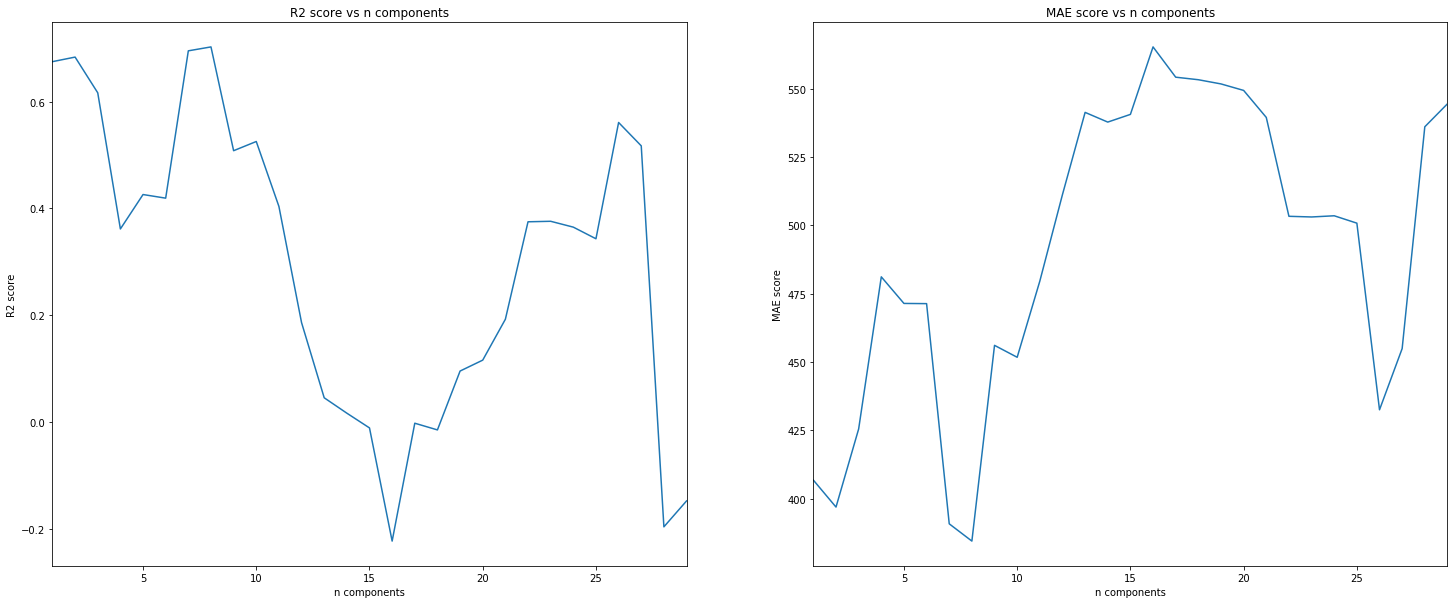

In [58]:
# plot the scores to see the best n_components
plt.figure(figsize = (25,10))
plt.subplot(1, 2, 1)
df_maer2['R2'].plot(kind='line')
plt.title('R2 score vs n components')
plt.ylabel('R2 score')
plt.xlabel('n components')

plt.subplot(1, 2, 2)
df_maer2['MAE'].plot(kind='line')
plt.title('MAE score vs n components')
plt.ylabel('MAE score')
plt.xlabel('n components')

plt.show()

In [59]:
# Evaluating best "n" for components
r2_max = df_maer2['R2'].idxmax()
print("Best n:", r2_max, "R2 score:", df_maer2['R2'][r2_max])

mse_min = df_maer2['MAE'].idxmin()
print("Best n:", mse_min, "MAE:", df_maer2['MAE'][mse_min])

Best n: 8 R2 score: 0.702437794834323
Best n: 8 MAE: 384.453991807298


In [60]:
# Using the optimal n components in linear regression
lreg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X_pca[:,:r2_max], y, test_size=0.2, random_state=0)
model = lreg.fit(X_train, y_train)

# check the result
y_pred = lreg.predict(X_test)
r2 = r2_score(y_test, y_pred) # r2 score
mse = mean_squared_error(y_test, y_pred) # mse
print("R2 score:", r2)
print('MAE:', mean_absolute_error(y_test, y_pred))

R2 score: 0.702437794834323
MAE: 384.453991807298


In [61]:
# Converting back to original coefficient/venues
eigenvectors = pca.components_
pcr_coefs = eigenvectors[:r2_max, :].T @ lreg.coef_

pcr_coefs.shape

(453,)

In [62]:
# Checking venues with largest Positive Coefficients
print('Largest positive Coefficients:', pcr_coefs[np.argsort(-pcr_coefs)[:10]])
print('Venue types with largest positive effect:', X.columns[np.argsort(-pcr_coefs)[:10]].values)


Largest positive Coefficients: [27.1365635  26.37114989 24.48971402 23.17792798 22.37910093 20.82259425
 19.07931784 18.65074785 17.94950424 17.71418012]
Venue types with largest positive effect: ['Donut Shop' 'Fried Chicken Joint' 'Fast Food Restaurant' 'Pharmacy'
 'Supermarket' 'Discount Store' 'Pizza Place' 'Caribbean Restaurant'
 'Bank' 'Gas Station']


In [63]:
# Checking venues with largest Negative Coefficients
print('Largest negative Coefficients:', pcr_coefs[np.argsort(pcr_coefs)[:10]])
print('Venue type with largest negative effect:', X.columns[np.argsort(pcr_coefs)[:10]].values)


Largest negative Coefficients: [-25.46236516 -24.46840418 -22.52016854 -22.20409907 -21.85425761
 -21.58767748 -20.51845358 -20.32699163 -20.28473859 -20.25174229]
Venue type with largest negative effect: ['Salad Place' 'Coffee Shop' 'Cycle Studio' 'Japanese Restaurant'
 'Gourmet Shop' 'Wine Bar' 'Mediterranean Restaurant' 'Bookstore'
 'Cupcake Shop' 'American Restaurant']


In [64]:
# Checking venues with least influence
coef_abs = abs(pcr_coefs)
print('Least influential Coefficients:', pcr_coefs[np.argsort(coef_abs)[:10]])
print('Venue types with least influence:', X.columns[np.argsort(coef_abs)[:10]].values)

Least influential Coefficients: [-0.01094574 -0.03198509 -0.04885     0.06301437 -0.06503475  0.0837393
  0.08823556  0.12239105 -0.17208389  0.19064819]
Venue types with least influence: ['Moroccan Restaurant' 'Himalayan Restaurant' 'Farm'
 'Eastern European Restaurant' 'Kitchen Supply Store'
 'Salvadoran Restaurant' 'Clothing Store' 'Beach Bar'
 'Egyptian Restaurant' 'Theme Park Ride / Attraction']


##### Interpretation of Results:
Using simple linear regression on individual venues did not yield a strong predictive model, resulting in a low R2 of 0.13; however, clustering neighborhoods based on venues yielded a stronger predictive model, resulting in a much higher R2 of 0.578. 

It would appear that the combination of certain venues in a group gives more predictive power than individual components of venues. So decided to go further and utilized PCA, which is an algorithm that reduces the dimensionality by utilizing the correlations of certain venues to each other in to clusters. 

Utilizing PCA and linear regressions, I am able to find a moderately strong relationship between certain venues and infection rates of an area. The model yielded an **R2 of 0.70 and a Mean Absolute Error of 384**, which can be interpreted that 68% of the variance of infection rates across neighborhoods could be explained/predicted from the composition of a neighborhood's top venues.

##### Discussion:
According to my analysis, it appears that neighborhoods that have establishments that are frequented by lower socioeconomic populations, such as **Fast Food Resturants and Bodegas** have higher rates of infections than neighborhoods that have venues that cater towards higher socioeconomic populations, such as **Cycle Studios and Wine Bars**. Speculating from this observation, it appears that people from poorer socioeconomic backgrounds are more negatively affected by this pandemic. 

##### Conclusion and Application of Findings:
By applying this model to any given set of coordinates or neighborhood, we can reasonably predict how drastic the effects of the pandemic could be in terms of infection rates based on the composition of the venues in the area. We can then allocate resources, such as medical supplies and personal to areas in most in need. We also need to be mindful that poorer communities are still at risk and should be closely monitored, as NYC reopens. Perhaps, one course of action would be to place more testing facilities and medical resources in neighborhoods at risk and placing more stricter reopening guidelines on those neighborhoods at risk to reduce the spread of the pandemic.


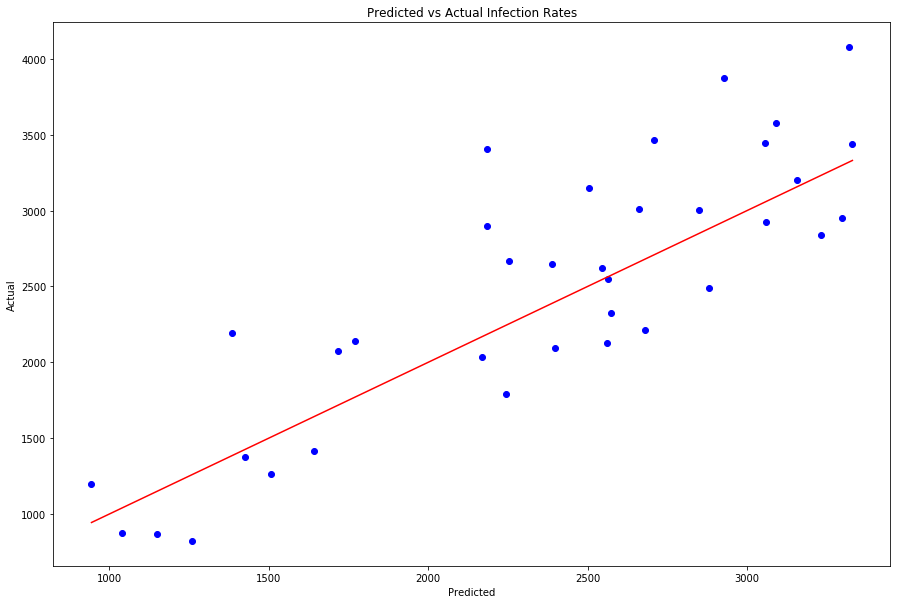

In [65]:
#plotting actual vs predicted
lineStart = y_pred.min() 
lineEnd = y_pred.max() 

plt.figure(figsize = (15,10))
plt.scatter(y_pred, y_test, color = 'blue')
plt.title('Predicted vs Actual Infection Rates')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.show()